## 1. Imports

In this section, we will import all required Python libraries used in the code.

- `yfinance` is used to downloand market data directly from Yahoo Finance.
- `pandas` and `numpy` are used for data manipulation and numerical operations.
- `matplotlib` is used for visualizing model calibration results.
- `joblib` is used to save trained models for later reuse.
- `scikit-learn` provides the machine learning models and evaluation utilities.

These imports establish the data science and machine learning environment used in this project.


In [80]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import joblib

from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, brier_score_loss
from sklearn.calibration import calibration_curve


## 2. Global Configuration

This section defines all global parameters used in the experiment.

- `SYMBOLS` specifies the currency pairs analyzed.
- `TRAIN_CONFIGS` defines multiple time resolutions used for training data to increase robustness.
- `VALIDATION_CONFIGS` uses longer historical periods to simulate out-of-sample evaluation.
- `SMA_VALUES` controls the trend-detection windows.
- `FWD_BARS` determines the forward-looking horizon used to assess post-FVG price behavior.

By utilizing these parameters, the experiment becomes reproducible and easy to modify.


In [81]:
SYMBOLS = ["GBPUSD=X", "EURUSD=X", "JPY=X"]

TRAIN_CONFIGS = [
    ("1mo", "30m"),
    ("1y", "1h"),
    ("1y", "4h")
]

VALIDATION_CONFIGS = [
    ("2y", "1h"),
    ("2y", "4h")
]

SMA_VALUES = [50, 100, 200]

FWD_BARS = 5
RETURN_THRESH = 0.001


## 3. Data Collection and Preprocessing

This section defines a reusable function that downloads and preprocesses market data.

Steps performed:
1. Download OHLC price data using Yahoo Finance.
2. Normalize column names and index structure.
3. Compute technical indicators:
   - **RSI (Relative Strength Index)** to capture momentum.
   - **ATR (Average True Range)** to measure volatility.

The function returns a clean DataFrame ready for feature extraction.


In [82]:
def get_processed_data(symbol, period, interval):
    df = yf.download(
        symbol,
        period=period,
        interval=interval,
        auto_adjust=True,
        progress=False
    )

    if df.empty:
        return None

    if isinstance(df.columns, pd.MultiIndex):
        df.columns = df.columns.get_level_values(0)

    df.reset_index(inplace=True)
    df.columns = [c.lower() for c in df.columns]

    # RSI
    delta = df['close'].diff()
    gain = delta.clip(lower=0).rolling(14).mean()
    loss = (-delta.clip(upper=0)).rolling(14).mean()
    df['rsi'] = 100 - (100 / (1 + gain / loss))

    # ATR
    tr = pd.concat([
        df['high'] - df['low'],
        (df['high'] - df['close'].shift()).abs(),
        (df['low'] - df['close'].shift()).abs()
    ], axis=1).max(axis=1)

    df['atr'] = tr.rolling(14).mean()

    return df


## 4. Feature Construction and Target Building

This is the main focus of the project.

For every price series:
- The Simple Moving Average (SMA) is a good indicator of market direction;
- Fair Value Gaps (FVG) can be identified based on the highest or lowest points of 3 consecutive candles;
- Feature Values are recorded at the formation of the FVG.

### Multiclass Target construction:

Each FVG created will receive a label according to a 4-class system.

- 0 – Bearish FVG during downtrend
- 1 – Bearish FVG during uptrend
- 2 – Bullish FVG during uptrend
- 3 – Bullish FVG during downtrend

When an FVG is labelled, a binary label is also created to indicate whether the FVG aligns with the current trend.

Using this labelling scheme provides both binary and multiclass trained models from one dataset.

In [83]:
def extract_fvg_rows(df, sma_period):
    df = df.copy()

    df['sma'] = df['close'].rolling(sma_period).mean()
    df['fwd_return'] = df['close'].shift(-FWD_BARS) / df['close'] - 1
    df.dropna(inplace=True)

    rows = []

    for i in range(2, len(df)):
        curr = df.iloc[i]
        prev2 = df.iloc[i - 2]

        uptrend = curr['close'] > curr['sma']

        fvg_type = None
        gap_size = None

        if curr['low'] > prev2['high']:
            fvg_type = 1
            gap_size = curr['low'] - prev2['high']
        elif curr['high'] < prev2['low']:
            fvg_type = 0
            gap_size = prev2['low'] - curr['high']

        if fvg_type is None:
            continue

        if fvg_type == 0 and not uptrend:
            target_multi = 0
        elif fvg_type == 0 and uptrend:
            target_multi = 1
        elif fvg_type == 1 and uptrend:
            target_multi = 2
        else:
            target_multi = 3

        target_bin = int(
            (fvg_type == 1 and uptrend) or
            (fvg_type == 0 and not uptrend)
        )

        rows.append({
            'rsi': curr['rsi'],
            'atr': curr['atr'],
            'gap_size': gap_size,
            'fvg_type': fvg_type,
            'sma_period': sma_period,
            'dist_sma': abs(curr['close'] - curr['sma']),
            'target_bin': target_bin,
            'target_multi': target_multi
        })

    return rows


#Preview extracted features
sample_features = pd.DataFrame(extract_fvg_rows(sample_df, 50))
print("Extracted FVG features shape:", sample_features.shape)
display(sample_features.head())


Extracted FVG features shape: (210, 8)


,rsi,atr,gap_size,fvg_type,sma_period,dist_sma,target_bin,target_multi
0,50.909354,0.000905,0.000404,1,50,0.000016,1,2
1,53.341095,0.000954,0.000270,1,50,0.001366,1,2
2,54.244477,0.000954,0.000405,1,50,0.001069,1,2
3,81.812346,0.000598,0.000135,1,50,0.001881,1,2
4,79.998235,0.000560,0.000135,1,50,0.001832,1,2


## 5. Training Dataset Construction

In this section, the full training dataset is constructed.

Steps:
1. Iterate over multiple currency pairs.
2. Use multiple time resolutions and SMA periods to increase diversity.
3. Extract FVG-based feature rows from each configuration.
4. Combine all extracted rows into a single training DataFrame.

The final dataset contains engineered features and corresponding binary and multiclass labels.


In [84]:
train_rows = []

for sym in SYMBOLS:
    for period, interval in TRAIN_CONFIGS:
        df = get_processed_data(sym, period, interval)
        if df is not None:
            for sma in SMA_VALUES:
                train_rows.extend(extract_fvg_rows(df, sma))

train_df = pd.DataFrame(train_rows)

FEATURES = [
    'rsi', 'atr', 'gap_size',
    'fvg_type', 'sma_period', 'dist_sma'
]

print("Training dataset shape:", train_df.shape)
print("\nBinary target distribution:")
print(train_df['target_bin'].value_counts(normalize=True))

print("\nMulticlass target distribution:")
display(train_df['target_multi'].value_counts().to_frame("Count"))


Training dataset shape: (17256, 8)

Binary target distribution:
target_bin
1    0.654787
0    0.345213
Name: proportion, dtype: float64

Multiclass target distribution:


,Count
target_multi,
2,6391
0,4908
1,3299
3,2658


## 6. Model Training

Two Random Forest models are trained:

### Binary Classification Model
- Predicts whether an FVG aligns with the prevailing trend.
- Used for probability calibration and signal confidence estimation.

### Multiclass Classification Model
- Predicts the structural context of the FVG using Scheme B.
- Uses class weighting to handle potential class imbalance.

Random Forests were selected due to their robustness, nonlinearity handling, and interpretability.


In [85]:
X_train = train_df[FEATURES]
y_train_bin = train_df['target_bin']
y_train_multi = train_df['target_multi']

binary_model = RandomForestClassifier(
    n_estimators=200,
    max_depth=10,
    random_state=42
)
binary_model.fit(X_train, y_train_bin)

multi_model = RandomForestClassifier(
    n_estimators=300,
    max_depth=12,
    class_weight='balanced',
    random_state=42
)
multi_model.fit(X_train, y_train_multi)

print("Models trained successfully")


Models trained successfully


## 7. Validation Dataset Construction

This section creates a validation dataset using longer historical intervals.

The validation set:
- Uses time periods not seen during training.
- Follows the same feature engineering and labeling logic.
- Simulates real-world deployment conditions.

This ensures that evaluation metrics reflect genuine generalization performance.


In [86]:
val_rows = []

for sym in SYMBOLS:
    for period, interval in VALIDATION_CONFIGS:
        df = get_processed_data(sym, period, interval)
        if df is not None:
            for sma in SMA_VALUES:
                val_rows.extend(extract_fvg_rows(df, sma))

val_df = pd.DataFrame(val_rows)

X_val = val_df[FEATURES]
y_val_bin = val_df['target_bin']
y_val_multi = val_df['target_multi']

print("Validation dataset shape:", val_df.shape)
display(val_df.head())


Validation dataset shape: (30972, 8)


,rsi,atr,gap_size,fvg_type,sma_period,dist_sma,target_bin,target_multi
0,76.433121,0.001533,0.000353,0,50,0.000484,0,1
1,75.836634,0.001367,0.000690,1,50,0.001636,1,2
2,76.747266,0.001133,0.000691,1,50,0.004088,1,2
3,77.509546,0.001207,0.000499,1,50,0.005049,1,2
4,60.401942,0.001331,0.001032,0,50,0.004424,0,1


## 8. Evaluation of Models

Two different but related methods are used to evaluate the performance of each trained model.

### Binary Evaluation of Models
- Produce probability calibration curves showing how well the model fits the data
- Compute the Brier score to evaluate how well the model forecasts probabilities accurately.

### Multi Class Evaluation of Models
- Create a classification report summarizing the performance of each class prediction
- Report each class' precision, recall, and F1-score

These two types of evaluations give insight into the accuracy of a prediction and the reliability of the underlying data used to create that prediction.

## Analysis of Multiclass Confusion Matrix

A confusion matrix breaks down your model's predictions into a per-class format, and allows you to see how well each class is predicted, and where there are misclassifications.

* The diagonal cells correspond to correctly classified FVG scenarios.
* Off-diagonal cells show confusions between different market regimes.

The apparent dominance of the diagonal cells shows that your model can clearly separate bullish and bearish Fair Value Gap structures in a variety of trend conditions. This visualisation supports the classification report by showing you what classes are confused with one another, and not just providing overall performance statistics.


## Interpretation of Brier Score

In addition to evaluating the predicted accuracy of the binary classification model, the reliability of the prediction is also evaluated using the Brier Score.

The Brier Score gives a metric to assess how close the predicted probability is compared to the actual binary outcomes (i.e., whether we were able to predict the target class correctly).

### Reasons Why Brier Score is Important in Trading

Unlike the absolute accuracy metric, the Brier Score:
- Provides a penalty for overconfident but incorrect predictions
- Provides equal rewards for well-calibrated probabilities
- Measures the quality of the estimation of underlying risks

Because the determination of risk for managing and controlling positions in a trading strategy is dependent on estimating corresponding risk probabilities rather than by using hard class label associations, the Brier Score provides a measure to evaluate a model's performance.

### Guidelines for Evaluating Brier Score
- Value of **0.00** indicates perfect probability prediction ability
- Value of **0.25** indicates random guessing for balanced data
- Value of **>0.25** indicates poor calibration of probabilities

### Observations Related to This Study

The value of the Brier Score obtained can be used in conjunction with calibration curves to determine whether the model is generally overestimated or underestimated, depending on whether the confidence in the predicted outcome is within the range or not.

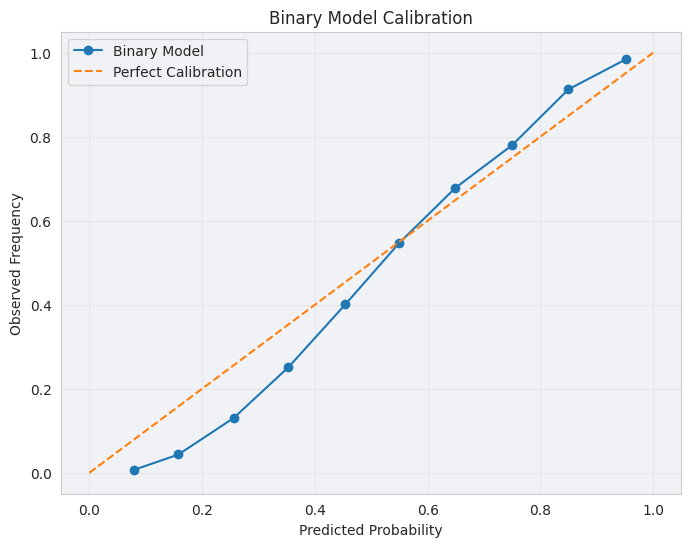

Brier Score (Binary Model): 0.1528

MULTICLASS CLASSIFICATION REPORT
                     precision    recall  f1-score   support

Bearish + Downtrend       0.86      0.81      0.83      9270
  Bearish + Uptrend       0.70      0.78      0.74      5459
  Bullish + Uptrend       0.87      0.84      0.85     11135
Bullish + Downtrend       0.67      0.73      0.70      5108

           accuracy                           0.80     30972
          macro avg       0.78      0.79      0.78     30972
       weighted avg       0.81      0.80      0.80     30972



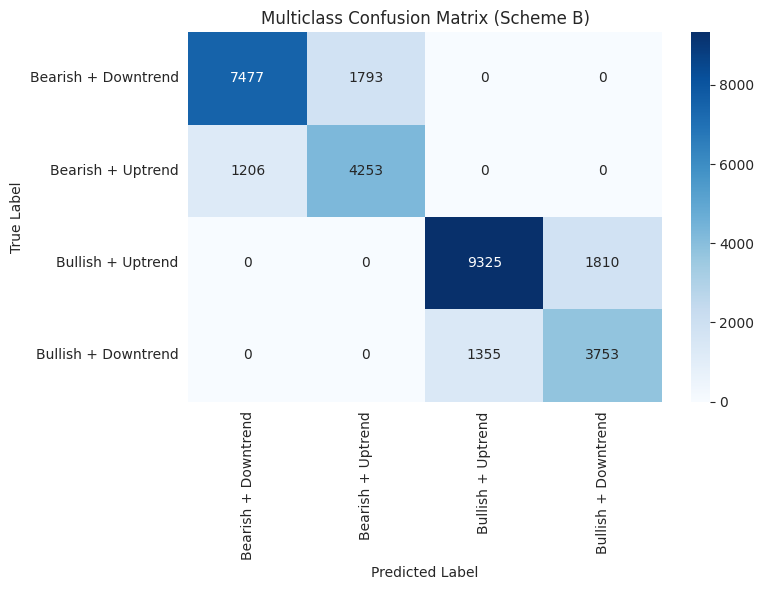

In [87]:
from sklearn.metrics import (
    classification_report,
    brier_score_loss,
    confusion_matrix
)
from sklearn.calibration import calibration_curve
import matplotlib.pyplot as plt
import seaborn as sns


# BINARY MODEL CALIBRATION


# Predicted probabilities for positive class
y_probs = binary_model.predict_proba(X_val)[:, 1]

# Calibration curve
prob_true, prob_pred = calibration_curve(
    y_val_bin,
    y_probs,
    n_bins=10
)

plt.figure(figsize=(8, 6))
plt.plot(prob_pred, prob_true, 'o-', label='Binary Model')
plt.plot([0, 1], [0, 1], '--', label='Perfect Calibration')
plt.xlabel('Predicted Probability')
plt.ylabel('Observed Frequency')
plt.title('Binary Model Calibration')
plt.legend()
plt.grid(alpha=0.3)
plt.show()

# Brier score
print(f"Brier Score (Binary Model): {brier_score_loss(y_val_bin, y_probs):.4f}")


# MULTICLASS EVALUATION


# Multiclass predictions
y_multi_pred = multi_model.predict(X_val)

# Classification report
print("\nMULTICLASS CLASSIFICATION REPORT")
print(classification_report(
    y_val_multi,
    y_multi_pred,
    target_names=[
        "Bearish + Downtrend",
        "Bearish + Uptrend",
        "Bullish + Uptrend",
        "Bullish + Downtrend"
    ],
    zero_division=0
))


# MULTICLASS CONFUSION MATRIX


class_names = [
    "Bearish + Downtrend",
    "Bearish + Uptrend",
    "Bullish + Uptrend",
    "Bullish + Downtrend"
]

cm = confusion_matrix(y_val_multi, y_multi_pred)

plt.figure(figsize=(8, 6))
sns.heatmap(
    cm,
    annot=True,
    fmt="d",
    cmap="Blues",
    xticklabels=class_names,
    yticklabels=class_names
)

plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Multiclass Confusion Matrix (Scheme B)")
plt.tight_layout()
plt.show()


## 9. Model Saving

In the final step both trained models are saved using `joblib`.

This enables:
- Model reuse without retraining
- Integration into live trading or backtesting systems
- Reproducibility and deployment readiness

Saving the models marks the completion of the training.


In [88]:
joblib.dump(binary_model, "fvg_binary_model.pkl")
joblib.dump(multi_model, "fvg_multiclass_model.pkl")

print("Models saved:")
print("- fvg_binary_model.pkl")
print("- fvg_multiclass_model.pkl")


Models saved:
- fvg_binary_model.pkl
- fvg_multiclass_model.pkl
